In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Define the transforms to be applied to the data
# Here, assume that the images are grayscale and need to be resized to 32x32
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



In [2]:
# Load the custom dataset
# Here, assume that the dataset is stored in the following directories:
# - train: contains training images
# - test: contains testing images
train_data = datasets.ImageFolder(root="E:/Project_A/project_share/Project_A_image_cross/train/left", transform=transform)
test_data_left = datasets.ImageFolder(root="E:/Project_A/project_share/Project_A_image_cross/class/left", transform=transform)
test_data_right = datasets.ImageFolder(root="E:/Project_A/project_share/Project_A_image_cross/class/right", transform=transform)
test_data_straight = datasets.ImageFolder(root="E:/Project_A/project_share/Project_A_image_cross/class/straight", transform=transform)
test_data_U = datasets.ImageFolder(root="E:/Project_A/project_share/Project_A_image_cross/class/U", transform=transform)

train_size = int (0.875*len(train_data))
train_dataset = data.Subset(train_data,range(train_size))
# Create the data loaders
batch_size = 30
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader_left = DataLoader(test_data_left, batch_size=batch_size, shuffle=False)
test_loader_right = DataLoader(test_data_right, batch_size=batch_size, shuffle=False)
test_loader_straight = DataLoader(test_data_straight, batch_size=batch_size, shuffle=False)
test_loader_U = DataLoader(test_data_U, batch_size=batch_size, shuffle=False)



In [3]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, pool_proj):
        super(InceptionModule, self).__init__()
        
        # 1x1 convolution branch
        self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)
        
        # 3x3 convolution branch
        self.branch3x3_reduce = nn.Conv2d(in_channels, reduce3x3, kernel_size=1)
        self.branch3x3 = nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1)
        
        # 5x5 convolution branch
        self.branch5x5_reduce = nn.Conv2d(in_channels, reduce5x5, kernel_size=1)
        self.branch5x5 = nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2)
        
        # Max pooling branch
        self.branch_pool = nn.Conv2d(in_channels, pool_proj, kernel_size=1)
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch3x3 = self.branch3x3_reduce(x)
        branch3x3 = self.branch3x3(branch3x3)
        
        branch5x5 = self.branch5x5_reduce(x)
        branch5x5 = self.branch5x5(branch5x5)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)

In [4]:
# Define the model architecture
class custom_net(nn.Module):
    def __init__(self):
        super(custom_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.inception3a = InceptionModule(16, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.fc1 = nn.Linear(480*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.avgpool2(x)
        # Apply Inception module
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = torch.relu(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x
# Create the model instance and set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = custom_net().to(device)

# Define the loss function, optimizer, and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
# Train the model
epochs = 6
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.3f}")
            running_loss = 0.0


Epoch: 1, Batch: 100, Loss: 1.573
Epoch: 1, Batch: 200, Loss: 1.460
Epoch: 2, Batch: 100, Loss: 1.381
Epoch: 2, Batch: 200, Loss: 1.312
Epoch: 3, Batch: 100, Loss: 1.267
Epoch: 3, Batch: 200, Loss: 1.169
Epoch: 4, Batch: 100, Loss: 1.071
Epoch: 4, Batch: 200, Loss: 1.019
Epoch: 5, Batch: 100, Loss: 0.958
Epoch: 5, Batch: 200, Loss: 0.883
Epoch: 6, Batch: 100, Loss: 0.856
Epoch: 6, Batch: 200, Loss: 0.803


In [6]:
# Evaluate the model left
model.eval()

# Create empty lists to store the predicted labels and ground truth labels
pred_labels_left = []
true_labels_left = []
correct_left = 0
total_left = 0
with torch.no_grad():
    for data in test_loader_left:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_left += labels.size(0)
        correct_left += (predicted == labels).sum().item()
        pred_labels_left += predicted.tolist()
        true_labels_left += labels.tolist()
        



In [7]:
# Evaluate the model right

# Create empty lists to store the predicted labels and ground truth labels
pred_labels_right = []
true_labels_right = []
correct_right = 0
total_right = 0
with torch.no_grad():
    for data in test_loader_right:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_right += labels.size(0)
        correct_right += (predicted == labels).sum().item()
        pred_labels_right += predicted.tolist()
        true_labels_right += labels.tolist()



In [8]:
# Evaluate the model straight

# Create empty lists to store the predicted labels and ground truth labels
pred_labels_straight = []
true_labels_straight = []
correct_straight = 0
total_straight = 0
with torch.no_grad():
    for data in test_loader_straight:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_straight += labels.size(0)
        correct_straight += (predicted == labels).sum().item()
        pred_labels_straight += predicted.tolist()
        true_labels_straight += labels.tolist()



In [9]:
# Evaluate the model U

# Create empty lists to store the predicted labels and ground truth labels
pred_labels_U = []
true_labels_U = []
correct_U = 0
total_U = 0
with torch.no_grad():
    for data in test_loader_U:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_U += labels.size(0)
        correct_U += (predicted == labels).sum().item()
        pred_labels_U += predicted.tolist()
        true_labels_U += labels.tolist()
        


In [10]:
# print accuracy
print('Accuracy of the model on the left test images: {:.2f}%'.format(100 * correct_left / total_left))        
print('Accuracy of the model on the right test images: {:.2f}%'.format(100 * correct_right / total_right))        
print('Accuracy of the model on the straight test images: {:.2f}%'.format(100 * correct_straight / total_straight))
print('Accuracy of the model on the U test images: {:.2f}%'.format(100 * correct_U / total_U))

Accuracy of the model on the left test images: 54.79%
Accuracy of the model on the right test images: 58.99%
Accuracy of the model on the straight test images: 55.32%
Accuracy of the model on the U test images: 54.02%


In [11]:
# calculate F1 scores
F1_left = f1_score(true_labels_left, pred_labels_left, average='macro')
F1_right = f1_score(true_labels_right, pred_labels_right, average='macro')
F1_straight = f1_score(true_labels_straight, pred_labels_straight, average='macro')
F1_U = f1_score(true_labels_U, pred_labels_U, average='macro')
print(f"F1_lelft = {F1_left}")
print(f"F1_right = {F1_right}")
print(f"F1_straight = {F1_straight}")
print(f"F1_U = {F1_U}")

# calculate the confusion matrixes using scikit-learn
cm_left = confusion_matrix(true_labels_left, pred_labels_left)
cm_right = confusion_matrix(true_labels_right, pred_labels_right)
cm_straight = confusion_matrix(true_labels_straight, pred_labels_straight)
cm_U = confusion_matrix(true_labels_U, pred_labels_U)


F1_lelft = 0.5164230663798197
F1_right = 0.5394769754383327
F1_straight = 0.527261130082466
F1_U = 0.5095155653439505


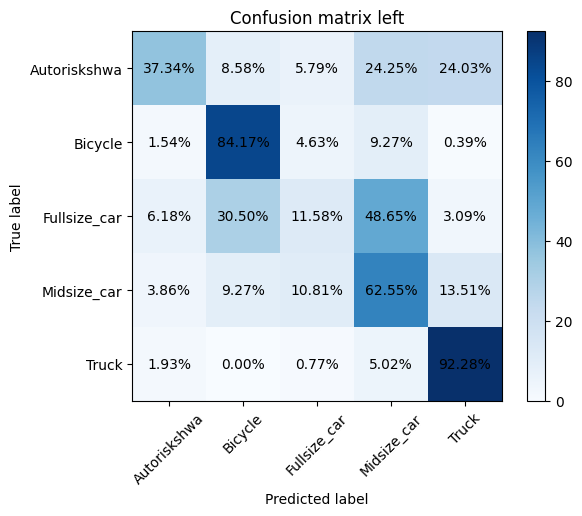

In [12]:
# Calculate the percentage of predictions for each class
cm_perc_left = cm_left.astype('float') / cm_left.sum(axis=1)[:, np.newaxis] * 100
cm_perc_right = cm_right.astype('float') / cm_right.sum(axis=1)[:, np.newaxis] * 100
cm_perc_straight = cm_straight.astype('float') / cm_straight.sum(axis=1)[:, np.newaxis] * 100
cm_perc_U = cm_U.astype('float') / cm_U.sum(axis=1)[:, np.newaxis] * 100

# Define class labels and tick marks
class_names = ['Autoriskshwa', 'Bicycle','Fullsize_car','Midsize_car','Truck']
tick_marks = np.arange(len(class_names))

# Plot confusion matrix
plt.imshow(cm_perc_left, cmap=plt.cm.Blues)
plt.title('Confusion matrix left')
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.colorbar()

# Add labels to the plot
thresh = cm_perc_left.max() / 2.
for i, j in np.ndindex(cm_perc_left.shape):
    plt.text(j, i, format(cm_perc_left[i, j], '.2f') + '%',
             ha="center", va="center",
             color="black" )

# Add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display the plot
plt.show()



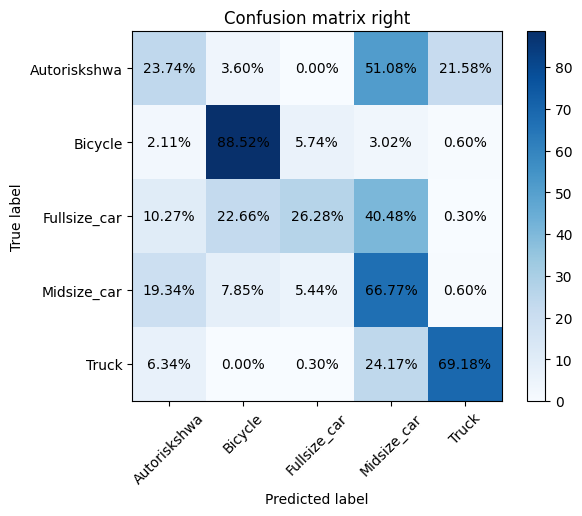

In [13]:
# Plot confusion matrix
plt.imshow(cm_perc_right, cmap=plt.cm.Blues)
plt.title('Confusion matrix right')
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.colorbar()

# Add labels to the plot
thresh = cm_perc_right.max() / 2.
for i, j in np.ndindex(cm_perc_right.shape):
    plt.text(j, i, format(cm_perc_right[i, j], '.2f') + '%',
             ha="center", va="center",
             color="black" )

# Add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display the plot
plt.show()

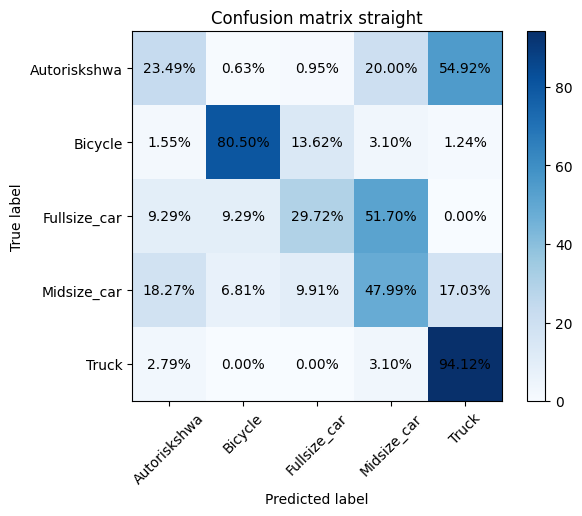

In [14]:
# Plot confusion matrix
plt.imshow(cm_perc_straight, cmap=plt.cm.Blues)
plt.title('Confusion matrix straight')
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.colorbar()

# Add labels to the plot
thresh = cm_perc_straight.max() / 2.
for i, j in np.ndindex(cm_perc_straight.shape):
    plt.text(j, i, format(cm_perc_straight[i, j], '.2f') + '%',
             ha="center", va="center",
             color="black" )

# Add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display the plot
plt.show()

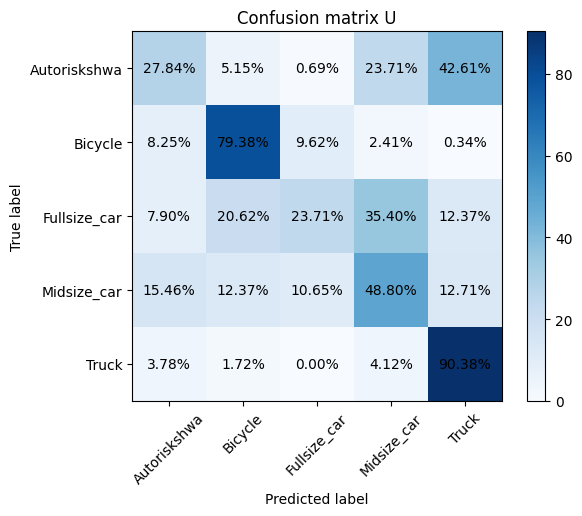

In [15]:
# Plot confusion matrix
plt.imshow(cm_perc_U, cmap=plt.cm.Blues)
plt.title('Confusion matrix U')
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.colorbar()

# Add labels to the plot
thresh = cm_perc_U.max() / 2.
for i, j in np.ndindex(cm_perc_U.shape):
    plt.text(j, i, format(cm_perc_U[i, j], '.2f') + '%',
             ha="center", va="center",
             color="black" )

# Add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display the plot
plt.show()